In [1]:
### here we compare CHiCAGO PIRs with BLUEPRINT annotations
### we then perform CHiCAGO vs ABC comparison
### Fig. 3B,C,E,F,G

library(data.table)
library(Chicago)
library(ggplot2)
library(eulerr)

consensus <- fread("ILC3_chicago_fres_5kb_abc_fres_extended_peakm.txt")

Warning message:
“package ‘Chicago’ was built under R version 3.6.3”
Warning message:
“replacing previous import ‘vctrs::data_frame’ by ‘tibble::data_frame’ when loading ‘dplyr’”


Welcome to CHiCAGO - version 1.14.0

If you are new to CHiCAGO, please consider reading the vignette through the command: vignette("Chicago").

NOTE: Default values of tlb.minProxOEPerBin and tlb.minProxB2BPerBin changed as of Version 1.1.5. No action is required unless you specified non-default values, or wish to re-run the pipeline on old chicagoData objects. See news(package="Chicago")



In [2]:
# load epigenetic data

atac <- fread("ILC3_ATAC_peaks.bed")
k27ac <- fread("ILC3_H3K27ac_peaks.bed")

# load rmaps
rmap_fres <- fread("hg38_dpnII.rmap")
rmap_5kb <- fread("human_DpnII_5K_sol_baits.rmap")

## function for merging epigenetic data with rmap

epirmap <- function(epiprof, rmap_fres, rmap_5kb, overlap_by){
  
  # overlap_by: "summit" or "region"
  
  if (overlap_by == "summit"){
      # define middle point of a peak
      epiprof[,mid := (V2 + V3) /2]
      epiprof[,mid_2 := (V2 + V3) /2]
      epiprof <- epiprof[,c("V1", "V2", "V3", "mid", "mid_2")]
      epiprof[,V1 := gsub("chr", "", V1)]
  }else{
      # define middle point of a peak
      epiprof[,mid := V2]
      epiprof[,mid_2 := V3]
      epiprof <- epiprof[,c("V1", "V2", "V3", "mid", "mid_2")]
      epiprof[,V1 := gsub("chr", "", V1)]
  }

  
  # assign peaks to fres rmap bins by summit
  setkey(epiprof, V1, mid, mid_2)
  setkey(rmap_fres, V1, V2, V3)
  epi_rmap <- foverlaps(epiprof, rmap_fres, by.x = c("V1", "mid", "mid_2"), by.y = c("V1", "V2", "V3"))
  epi_rmap <- epi_rmap[,c("V1", "mid", "mid_2", "V4")]
  setnames(epi_rmap, "V4", "fres_ID")
  
  # assign peaks to 5kb rmap bins by summit
  setkey(epi_rmap, V1, mid, mid_2)
  setkey(rmap_5kb, V1, V2, V3)
  epi_rmap <- foverlaps(epi_rmap, rmap_5kb, by.x = c("V1", "mid", "mid_2"), by.y = c("V1", "V2", "V3"))
  epi_rmap <- epi_rmap[,c("V1", "mid", "mid_2", "fres_ID", "V4")]
  setnames(epi_rmap, "V4", "5kb_ID")

  
  return(epi_rmap)
}

atac_rmap <- epirmap(atac, rmap_fres, rmap_5kb, "summit")
k27ac_rmap <- epirmap(k27ac, rmap_fres, rmap_5kb, "summit")


In [8]:
### selecting active or open merged chicago PIRs

chicago_consensus <- consensus[chicago_fres >= 5 | chicago_5kb >= 5][,atac := ifelse(oeID %in% atac_rmap$fres_ID, "TRUE", "FALSE")]
chicago_consensus <- chicago_consensus[,k27ac := ifelse(oeID %in% k27ac_rmap$fres_ID, "TRUE", "FALSE")]


In [14]:
head(chicago_consensus)

baitChr,baitStart,baitEnd,baitID,baitName,oeChr,oeStart,oeEnd,oeID,oeName,baitID_5kb,oeID_5kb,dist,chicago_fres,chicago_5kb,ABC.Score,atac,k27ac
<chr>,<int>,<int>,<int>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,995927,1000058,2052,HES4,1,989911,990058,2027,,173,171,-5475,NA,5.148217,NA,FALSE,FALSE
1,995927,1000058,2052,HES4,1,990059,990235,2028,,173,171,-5475,NA,5.148217,NA,FALSE,FALSE
1,995927,1000058,2052,HES4,1,990236,990776,2029,,173,171,-5475,NA,5.148217,NA,FALSE,FALSE
1,995927,1000058,2052,HES4,1,990777,991054,2030,,173,171,-5475,NA,5.148217,NA,FALSE,FALSE
1,995927,1000058,2052,HES4,1,991055,991149,2031,,173,171,-5475,NA,5.148217,NA,FALSE,FALSE
1,995927,1000058,2052,HES4,1,991150,991423,2032,,173,171,-5475,NA,5.148217,NA,FALSE,FALSE


In [15]:
nrow(unique(chicago_consensus[atac == TRUE | k27ac == TRUE][,c("oeChr", "oeStart", "oeEnd")]))
nrow(unique(chicago_consensus[,c("oeChr", "oeStart", "oeEnd")]))

[1] 18231

[1] 557577

In [8]:
#### integrate with blueprint
library(data.table)
regbuild <- fread("Ensembl96_GRCh38_RegBuild.txt")


### regbuild open or active with ALL bins overlapping the feature (enhancer or open chromatin) marked as containing it

bp_all <- regbuild
colnames(bp_all) <- c("V1", "V2", "V3", "Feature_type", "feature_type_dscr")
bp_all_rmap <- epirmap(bp_all, rmap_fres, rmap_5kb, "region")


bp_all_rmap_annot <- merge(bp_all_rmap, bp_all, by.x = c("V1", "mid", "mid_2"), by.y = c("V1", "V2", "V3"))


In [25]:
## annotating chicago merged PIRs with blueprint annotations

chicago_consensus_bp <- merge(unique(chicago_consensus[,c("oeID", "atac", "k27ac")]), unique(bp_all_rmap_annot[,c("fres_ID", "Feature_type")]), 
                       by.x = "oeID", by.y = "fres_ID", all.x = TRUE)


In [26]:
chicago_consensus_bp[,atac_k27ac := ifelse((atac == TRUE | k27ac == TRUE), "TRUE", "FALSE")]
chicago_consensus_bp[,Feature_type := ifelse(is.na(Feature_type), "not_annotated", Feature_type)]


In [27]:
unique_actop_oe <- length(unique(chicago_consensus_bp[atac_k27ac == TRUE]$oeID))
unique_notactop_oe <- length(unique(chicago_consensus_bp[atac_k27ac == FALSE]$oeID))

In [28]:
unique_actop_oe
unique_notactop_oe

[1] 18231

[1] 539346

In [29]:
chicago_consensus_bp_sum <- chicago_consensus_bp[,.N, by = c("Feature_type", "atac_k27ac")]
chicago_consensus_bp_sum[,resolution := "chicago_consensus"]
chicago_consensus_bp_sum[,ratio := ifelse(atac_k27ac == FALSE, 100*N/unique_notactop_oe, 100*N/18231)]

In [31]:
chicago_consensus_bp_sum

Feature_type,atac_k27ac,N,resolution,ratio
<chr>,<chr>,<int>,<chr>,<dbl>
CTCF Binding Site,FALSE,56177,chicago_consensus,10.4157628
not_annotated,FALSE,360608,chicago_consensus,66.8602344
Promoter,FALSE,49703,chicago_consensus,9.2154202
Promoter,TRUE,9203,chicago_consensus,50.4799517
CTCF Binding Site,TRUE,8658,chicago_consensus,47.4905381
Promoter Flanking Region,FALSE,64332,chicago_consensus,11.9277792
Open chromatin,FALSE,9055,chicago_consensus,1.6788852
TF binding site,FALSE,4135,chicago_consensus,0.7666693
Enhancer,FALSE,21988,chicago_consensus,4.0767893


In [41]:
chicago_consensus_bp_sum$Feature_type <- factor(chicago_consensus_bp_sum$Feature_type, 
                                     levels = c("not_annotated", 'Open chromatin', 'Enhancer', 'TF binding site',
                                               "CTCF Binding Site", "Promoter", "Promoter Flanking Region"))

p <- ggplot(chicago_consensus_bp_sum[atac_k27ac == "TRUE"], aes(y=ratio, x=Feature_type, fill = "#fdae61")) + 
        geom_bar(position="stack", stat="identity") +
        #       scale_fill_manual(values = c("chicago_fragment_resolution" = "#045a8d",
        #                                    "chicago_5kb_resolution"="#74a9cf",
        #                                    "chicago_consensus" = "#969696")) + 
        ylab("% active PIRs with feature") +
        xlab("BLUEPRINT annotated features") +
        theme(axis.text.x = element_text(size = 6, angle = 45, vjust = 1, hjust=1),
            axis.title.x= element_blank(),
            axis.text.y = element_text(size = 6),
            axis.title.y = element_text(size = 6, colour = "grey30"),
            legend.position="none",
            panel.background = element_rect(fill = "white"),
            axis.line.x=element_line(color="grey30"),
            axis.line.y=element_line(color="grey30")
            )


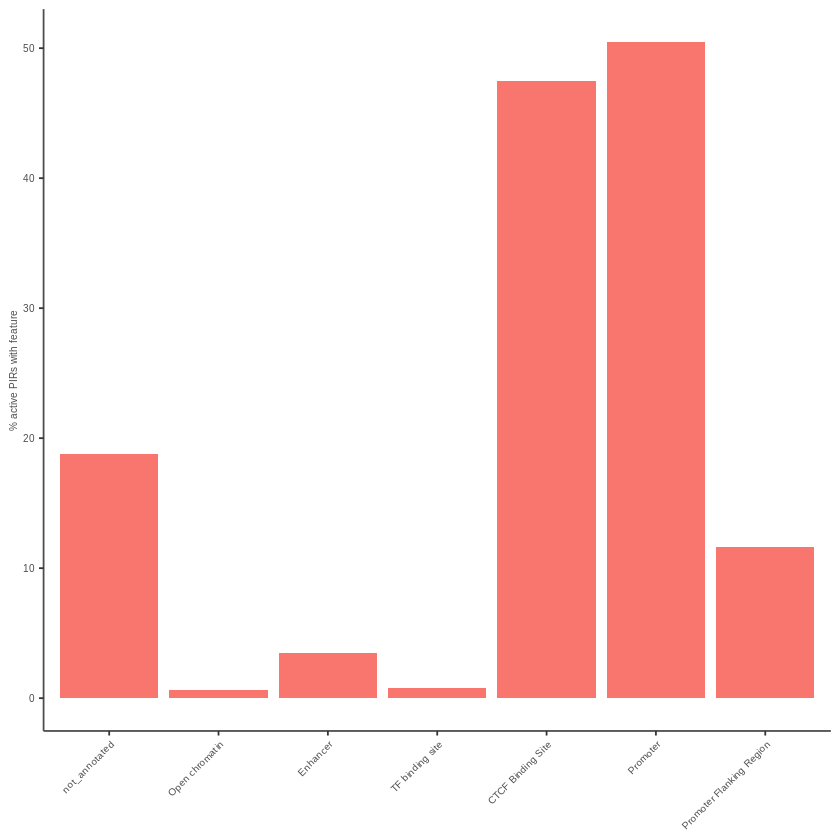

In [42]:
p

In [43]:
ggsave("ILC_merged_act_PIRs_pc_Blueprint_annotation.pdf", p, width = 2.5, height = 3, useDingbats=FALSE)


Warning message:
“Removed 2 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 2 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 2 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 2 rows containing non-finite values (stat_summary).”


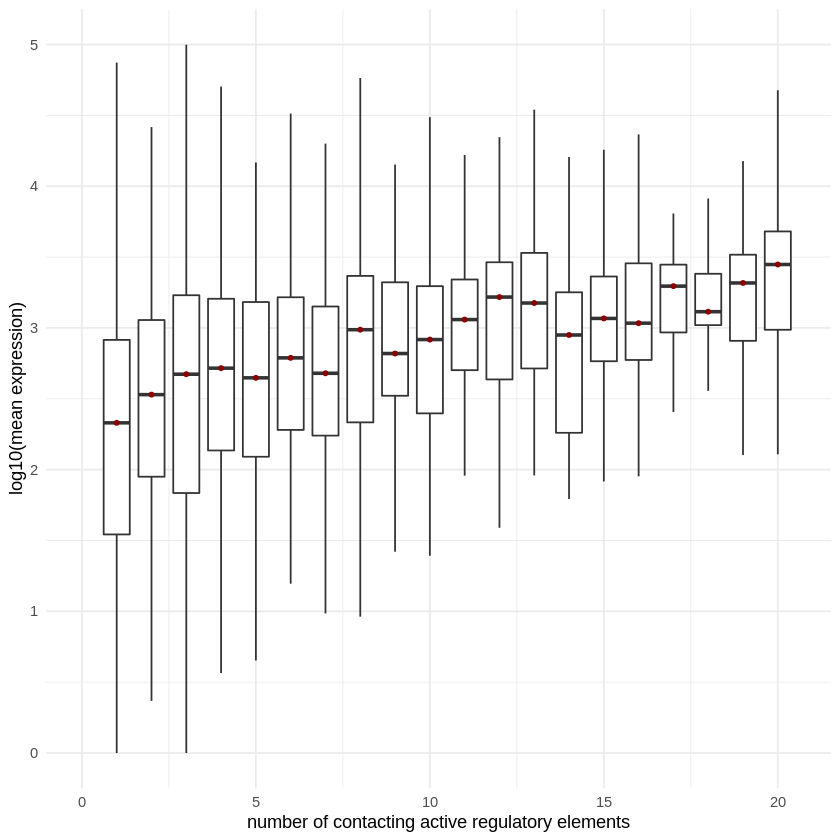

In [28]:
### checking correlation of the number of active elements with gene expression

ilc_abc_re <- fread("ILC_5kb_within_newbmap_CHiCAGO_ABC_peakm_RE.tsv")

consensus_actop_pirs <- unique(chicago_consensus[atac == TRUE | k27ac == TRUE][, c("baitName", "baitID", "oeID")])

consensus_actop_pirs_ge <- merge(consensus_actop_pirs, ilc_abc_re[,c("Gene_Name", "Mean_Gene_Expression")], 
                      by.x = c("baitName"), by.y = c("Gene_Name"), all.x = TRUE)

consensus_actop_pirs_ge <- consensus_actop_pirs_ge[!is.na(Mean_Gene_Expression)]
consensus_actop_pirs_ge_sum <- consensus_actop_pirs_ge[,.N, by = c("baitName", "Mean_Gene_Expression")]

## collapsing gene expression at 20

consensus_actop_pirs_ge_sum[,N := ifelse(N >=20, 20, N)]

p1 <- ggplot(consensus_actop_pirs_ge_sum, aes(N, log(Mean_Gene_Expression,10))) +
        geom_boxplot(aes(group = cut_width(N, 1)), outlier.alpha = 0) +
        ylim(0,5) + xlim(0,20.5) + 
        theme_minimal() +
        stat_summary(fun=median, geom="point",colour="darkred", size=1) +
        xlab("number of contacting active regulatory elements") + ylab("log10(mean expression)")

p1
ggsave("ILC_merged_actop_PIRs_GE.pdf", p1, width = 2.5, height = 3.5, useDingbats=FALSE)



In [50]:
### selecting active or open merged chicago PIRs

chic_abc_consensus <- consensus[,atac := ifelse(oeID %in% atac_rmap$fres_ID, "TRUE", "FALSE")]
chic_abc_consensus <- chic_abc_consensus[,k27ac := ifelse(oeID %in% k27ac_rmap$fres_ID, "TRUE", "FALSE")]

chic_abc_consensus[,chicago_fres := ifelse(is.na(chicago_fres), 0, chicago_fres)]
chic_abc_consensus[,chicago_5kb := ifelse(is.na(chicago_5kb), 0, chicago_5kb)]
chic_abc_consensus[,ABC.Score := ifelse(is.na(ABC.Score), 0, ABC.Score)]

In [51]:
nrow(unique(chic_abc_consensus[atac == TRUE | k27ac == TRUE][,c("oeID")]))
nrow(unique(chic_abc_consensus[ABC.Score>=5 & chicago_fres<5 & chicago_5kb<5]
            [atac == TRUE | k27ac == TRUE][,c("oeID")]))
nrow(unique(chic_abc_consensus[ABC.Score<5  & (chicago_fres >=5 | chicago_5kb >=5)]
            [atac == v TRUE | k27ac == TRUE][,c("oeID")]))
nrow(unique(chic_abc_consensus[ABC.Score>=5 & (chicago_fres >=5 | chicago_5kb >=5)]
            [atac == TRUE | k27ac == TRUE][,c("oeID")]))

[1] 22658

[1] 7351

[1] 17504

[1] 1640

In [89]:
chic_abc_actop_consensus <- chic_abc_consensus[atac == TRUE | k27ac == TRUE][,type := ifelse((ABC.Score>=5 & chicago_fres<5 & chicago_5kb<5), "ABC",
                                   ifelse((ABC.Score<5  & (chicago_fres >=5 | chicago_5kb >=5)), "CHiCAGO", "both"))]

In [90]:
chic_abc_actop_consensus_sum <- unique(chic_abc_actop_consensus[,c("oeID", "type")])[,.N, by = "type"]

In [91]:
chic_abc_actop_consensus_sum

type,N
<chr>,<int>
ABC,7351
both,1640
CHiCAGO,17504


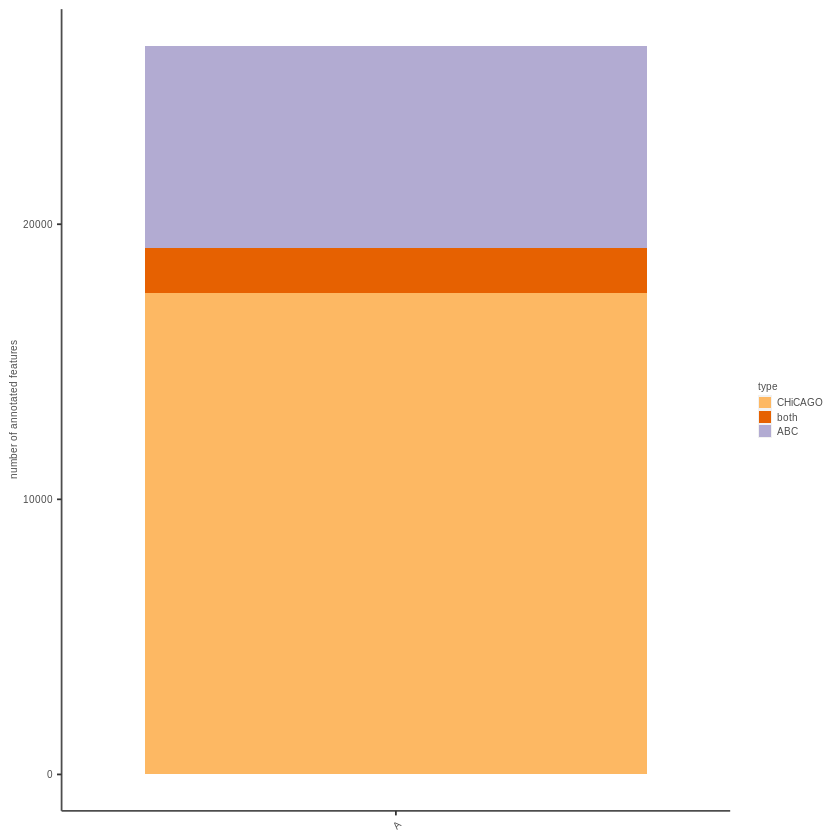

In [85]:
p2 <- ggplot(chic_abc_actop_consensus_sum, aes(y=N, x="A", fill = type)) + 
      geom_bar(position="stack", stat="identity") +
      scale_fill_manual(values = c("CHiCAGO" = "#fdb863",
                                   "both"="#e66101",
                                   "ABC" = "#b2abd2")) + 
      ylab("number of annotated features") +
      theme(axis.text.x = element_text(size = 6, angle = 45, vjust = 1, hjust=1),
            axis.title.x= element_blank(),
            axis.text.y = element_text(size = 6),
            axis.title.y = element_text(size = 6, colour = "grey30"),
            legend.title = element_text(size=6, colour = "grey30"),
            legend.text = element_text(size=6, colour = "grey30"),
            legend.key.width = unit(0.3, 'cm'),
            legend.key.height = unit(0.3, 'cm'),
            panel.background = element_rect(fill = "white"),
            axis.line.x=element_line(color="grey30"),
            axis.line.y=element_line(color="grey30")
            )

p2
ggsave("ILC_actop_merged_PIRs_vs_ABC.pdf", p2, width = 2.5, height = 3.5, useDingbats=FALSE)


Warning message:
“Removed 2 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 2 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 2 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 2 rows containing non-finite values (stat_summary).”


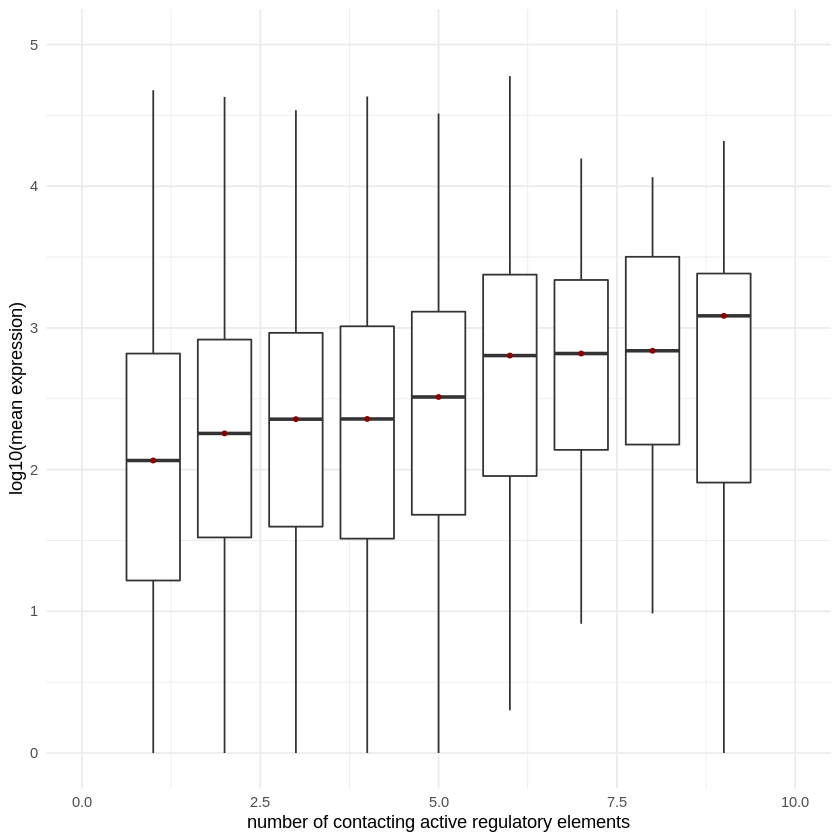

In [87]:
abc_actop_pirs <- unique(chic_abc_consensus[ABC.Score >= 5][atac == TRUE | k27ac == TRUE][, c("baitName", "baitID", "oeID")])

abc_actop_pirs_ge <- merge(abc_actop_pirs, ilc_abc_re[,c("Gene_Name", "Mean_Gene_Expression")], 
                      by.x = c("baitName"), by.y = c("Gene_Name"), all.x = TRUE)

abc_actop_pirs_ge <- abc_actop_pirs_ge[!is.na(Mean_Gene_Expression)]
abc_actop_pirs_ge_sum <- abc_actop_pirs_ge[,.N, by = c("baitName", "Mean_Gene_Expression")]

abc_actop_pirs_ge_sum[,N := ifelse(N >=9, 9, N)]

p3 <- ggplot(abc_actop_pirs_ge_sum, aes(N, log(Mean_Gene_Expression,10))) +
        geom_boxplot(aes(group = cut_width(N, 1)), outlier.alpha = 0) +
        ylim(0,5) + xlim(0,10) + 
        theme_minimal() +
        stat_summary(fun=median, geom="point",colour="darkred", size=1) +
        xlab("number of contacting active regulatory elements") + ylab("log10(mean expression)")

p3
ggsave("ILC_ABC_actop_PIRs_GE.pdf", p3, width = 2.5, height = 3.5, useDingbats=FALSE)


In [98]:
chic_abc_actop_consensus[,dist := ((oeEnd + oeStart)/2 - (baitStart + baitEnd)/2)]

Warning message:
“Removed 10342 rows containing non-finite values (stat_density).”
Warning message:
“Removed 10342 rows containing non-finite values (stat_density).”


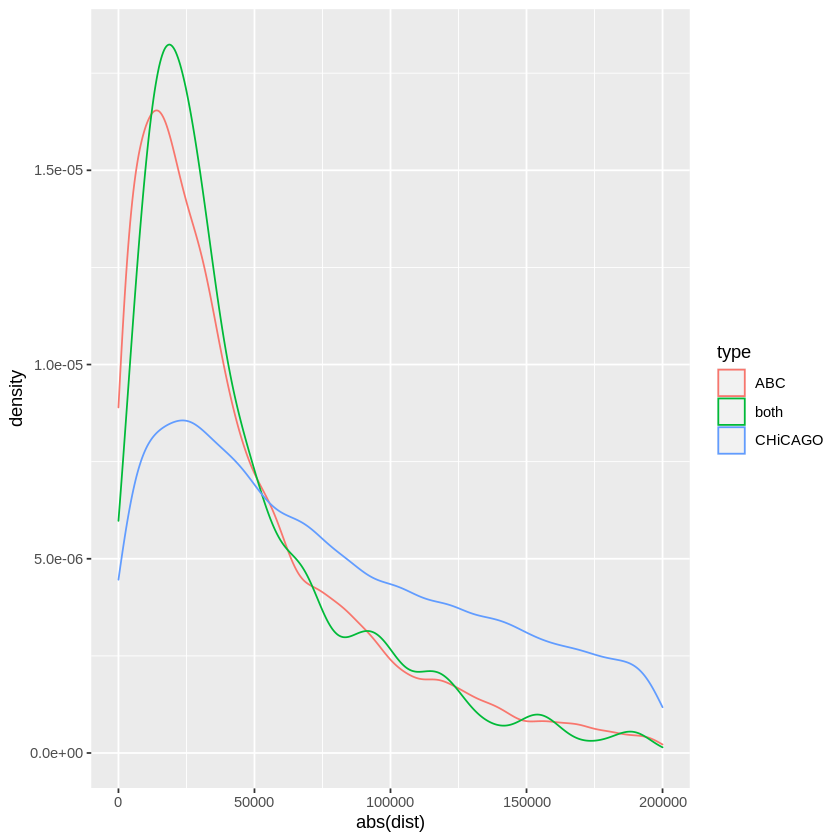

In [101]:
p4 <- ggplot(chic_abc_actop_consensus, aes(x=abs(dist), color=type)) +
    geom_density() +
    xlim(0,200000)

p4
ggsave("ILC_actop_merged_PIR_vs_ABC_distance.pdf", p4, width = 4, height = 3.5, useDingbats=FALSE)
